In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

<3>WSL (21 - Relay) ERROR: CreateProcessParseCommon:863: Failed to translate c:\Users\user\Desktop\RL
<3>WSL (21 - Relay) ERROR: CreateProcessParseCommon:909: getpwuid(0) failed 2
<3>WSL (21 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate c:\Users\user\AppData\Local\Microsoft\WindowsApps
<3>WSL (21 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate c:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\Scripts
<3>WSL (21 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate C:\Users\user\AppData\Local\cloud-code\installer\google-cloud-sdk\bin
<3>WSL (21 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate C:\Program Files (x86)\VMware\VMware Workstation\bin\
<3>WSL (21 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate C:\Program Files\Axiom\AxiomJDK-Pro-21\bin\
<3>WSL (21 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate C:\Windows\System32\

In [7]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt


In [8]:
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array")

state_size = env.observation_space.n
action_size = env.action_space.n

In [9]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [10]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



In [14]:
def one_hot_encode(state, state_size):
    vec = np.zeros(state_size)
    vec[state] = 1
    return torch.tensor([vec], dtype=torch.float32)


In [15]:
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array")
state_size = env.observation_space.n
action_size = env.action_space.n

policy_net = DQN(state_size, action_size)
target_net = DQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayMemory(10000)




In [16]:
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update = 10
episodes = 2000

rewards = []


In [17]:
for episode in range(episodes):
    state = env.reset()[0]
    state = one_hot_encode(state, state_size)
    total_reward = 0

    for t in range(100):
        # Выбор действия
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, action_size - 1)
        else:
            with torch.no_grad():
                action = policy_net(state).argmax().item()

        # Выполнение действия
        next_state, reward, done, _, _ = env.step(action)
        next_state = one_hot_encode(next_state, state_size)

        # Сохранение опыта
        memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Обучение модели
        if len(memory) > batch_size:
            batch = memory.sample(batch_size)
            states, actions, rewards_batch, next_states, dones = zip(*batch)

            states = torch.cat(states)
            actions = torch.tensor(actions).unsqueeze(1)
            rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32)
            next_states = torch.cat(next_states)
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = policy_net(states).gather(1, actions).squeeze()
            next_q_values = target_net(next_states).max(1)[0]
            target_q_values = rewards_batch + gamma * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Уменьшаем epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)

    # Обновление целевой сети
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if (episode + 1) % 200 == 0:
        print(f"Эпизод: {episode + 1}, средняя награда: {np.mean(rewards[-200:]):.3f}, epsilon: {epsilon:.3f}")


C:\Users\user\AppData\Local\Temp\ipykernel_15608\492136875.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor([vec], dtype=torch.float32)


Эпизод: 200, средняя награда: 0.030, epsilon: 0.367
Эпизод: 400, средняя награда: 0.175, epsilon: 0.135
Эпизод: 600, средняя награда: 0.405, epsilon: 0.049
Эпизод: 800, средняя награда: 0.570, epsilon: 0.018
Эпизод: 1000, средняя награда: 0.610, epsilon: 0.010
Эпизод: 1200, средняя награда: 0.690, epsilon: 0.010
Эпизод: 1400, средняя награда: 0.620, epsilon: 0.010
Эпизод: 1600, средняя награда: 0.625, epsilon: 0.010
Эпизод: 1800, средняя награда: 0.660, epsilon: 0.010
Эпизод: 2000, средняя награда: 0.640, epsilon: 0.010


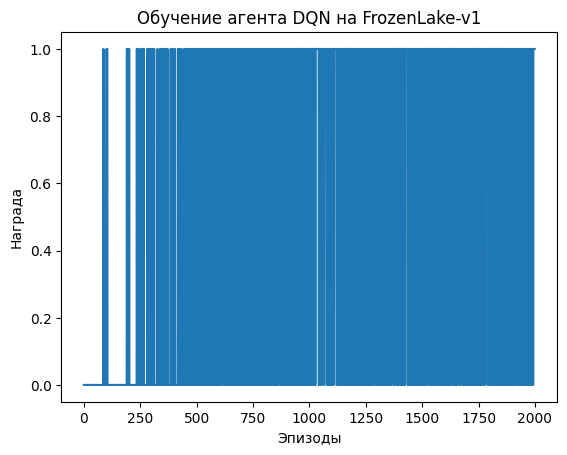

In [21]:
plt.plot(range(episodes), rewards)
plt.xlabel("Эпизоды")
plt.ylabel("Награда")
plt.title("Обучение агента DQN на FrozenLake-v1")
plt.show()


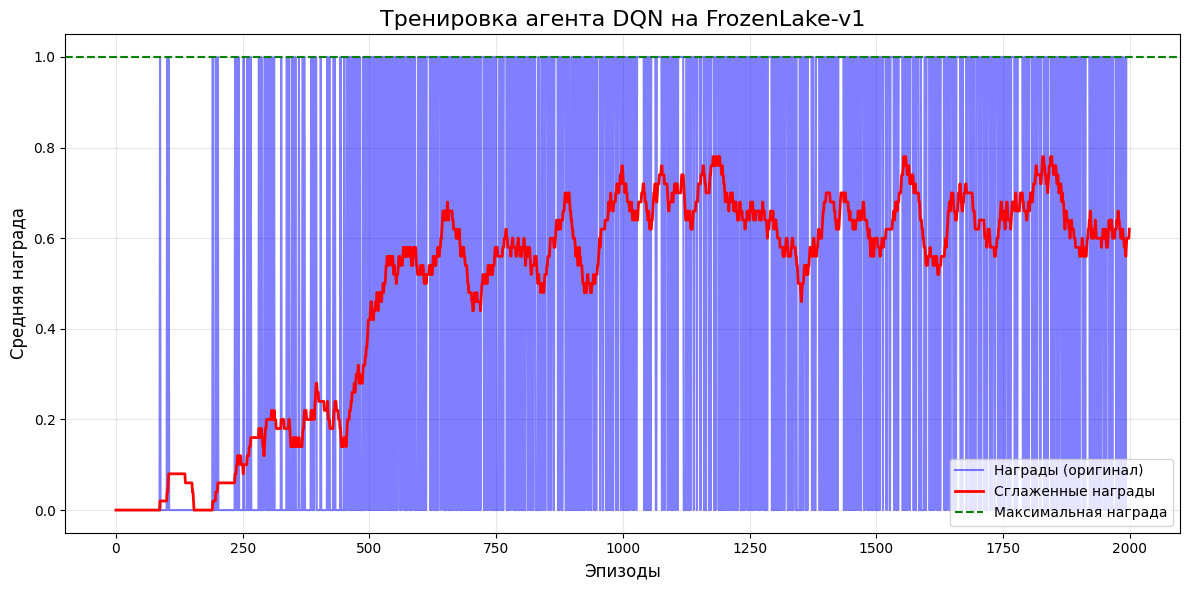

In [22]:
# Сглаживание наград
def smooth_rewards(rewards, window=50):
    smoothed = []
    for i in range(len(rewards)):
        start = max(0, i - window + 1)
        smoothed.append(np.mean(rewards[start:i+1]))
    return smoothed

smoothed_rewards = smooth_rewards(rewards)

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(rewards, label="Награды (оригинал)", alpha=0.5, color="blue")
plt.plot(smoothed_rewards, label="Сглаженные награды", color="red", linewidth=2)
plt.axhline(y=max(rewards), color='green', linestyle='--', label="Максимальная награда")

# Настройка визуального вида
plt.grid(alpha=0.3)
plt.xlabel("Эпизоды", fontsize=12)
plt.ylabel("Средняя награда", fontsize=12)
plt.title("Тренировка агента DQN на FrozenLake-v1", fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()

# Показ графика
plt.show()


Общая награда: 1.0


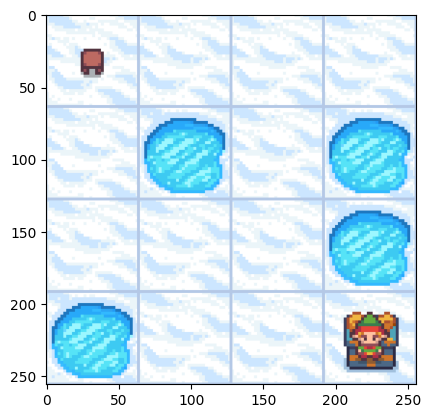

In [19]:
import time

display.clear_output(wait=True)
state = env.reset()[0]
state = one_hot_encode(state, state_size)  # Кодируем состояние для DQN
done = False
total_reward = 0
print(f"Эпизод {episode + 1}:")

while not done:
    # Выбор действия с использованием обученной модели
    with torch.no_grad():
        action = policy_net(state).argmax().item()

    # Выполняем действие
    next_state, reward, done, _, _ = env.step(action)
    next_state = one_hot_encode(next_state, state_size)  # Кодируем следующее состояние
    total_reward += reward
    state = next_state

    # Отображаем текущую визуализацию среды
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.3)  # Добавляем задержку для визуального эффекта

print(f"Общая награда: {total_reward}")

